#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 설치 및 불러오기

* 라이브러리 로딩

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [4]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [5]:
data01_train = pd.read_csv(path + 'data01_train.csv')
data01_test = pd.read_csv(path + 'data01_test.csv')

In [6]:
data01_test.drop('subject', axis = 1, inplace = True)
data01_train.drop('subject', axis = 1, inplace = True)

In [7]:
display(data01_test.head())
display(data01_train.head())

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [8]:
data01_train.shape, data01_test.shape

((5881, 562), (1471, 562))

In [9]:
display(data01_test.describe())
display(data01_train.describe())

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,...,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000
mean,0.273198,-0.017281,-0.108123,-0.614634,-0.515427,-0.607533,-0.639950,-0.530760,-0.609256,-0.481055,...,0.118651,-0.311513,-0.632273,0.009324,0.015666,0.006272,-0.001510,-0.481737,0.055771,-0.064194
std,0.079989,0.045957,0.049082,0.448480,0.506094,0.424243,0.422994,0.489381,0.418536,0.542756,...,0.258112,0.313792,0.296179,0.324864,0.452616,0.608954,0.483028,0.522714,0.298124,0.281645
min,-1.000000,-1.000000,-0.418354,-0.999717,-0.999873,-1.000000,-0.999867,-1.000000,-0.999879,-0.948723,...,-1.000000,-0.995357,-0.994664,-0.937468,-0.990492,-0.995222,-0.969066,-0.999380,-0.995073,-1.000000
25%,0.263787,-0.024792,-0.120733,-0.992669,-0.979082,-0.981070,-0.993498,-0.979214,-0.980659,-0.936791,...,-0.035193,-0.546342,-0.844547,-0.119166,-0.265533,-0.485998,-0.380300,-0.814060,-0.017413,-0.148445
50%,0.277322,-0.017187,-0.108124,-0.952426,-0.867309,-0.869890,-0.958705,-0.873891,-0.863451,-0.890491,...,0.135282,-0.347433,-0.706699,0.005049,0.023421,-0.005036,0.002408,-0.708911,0.178814,-0.002243
75%,0.288058,-0.010238,-0.096606,-0.245405,-0.030639,-0.260223,-0.297260,-0.058824,-0.256657,-0.030692,...,0.289832,-0.125796,-0.516910,0.135698,0.312690,0.518184,0.374583,-0.486534,0.248126,0.096674
max,0.631510,0.359587,0.543939,0.899922,0.782590,0.931308,0.950758,0.602458,0.784041,0.821218,...,0.860512,0.941113,0.894210,0.980889,0.991899,0.994366,0.979522,1.000000,0.432496,0.992766


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [10]:
data01_test.info(), data01_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 6.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


(None, None)

In [11]:
data01_test.isnull().sum(), data01_train.isnull().sum()

(tBodyAcc-mean()-X                       0
 tBodyAcc-mean()-Y                       0
 tBodyAcc-mean()-Z                       0
 tBodyAcc-std()-X                        0
 tBodyAcc-std()-Y                        0
                                        ..
 angle(tBodyGyroJerkMean,gravityMean)    0
 angle(X,gravityMean)                    0
 angle(Y,gravityMean)                    0
 angle(Z,gravityMean)                    0
 Activity                                0
 Length: 562, dtype: int64,
 tBodyAcc-mean()-X                       0
 tBodyAcc-mean()-Y                       0
 tBodyAcc-mean()-Z                       0
 tBodyAcc-std()-X                        0
 tBodyAcc-std()-Y                        0
                                        ..
 angle(tBodyGyroJerkMean,gravityMean)    0
 angle(X,gravityMean)                    0
 angle(Y,gravityMean)                    0
 angle(Z,gravityMean)                    0
 Activity                                0
 Length: 562, dtype: int64

### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [12]:
data01_test['Activity'].unique()

array(['SITTING', 'STANDING', 'WALKING', 'WALKING_UPSTAIRS', 'LAYING',
       'WALKING_DOWNSTAIRS'], dtype=object)

In [13]:
data01_test['Activity'].value_counts()

,count
Activity,
LAYING,292
STANDING,287
SITTING,254
WALKING,228
WALKING_UPSTAIRS,215
WALKING_DOWNSTAIRS,195


In [14]:
data01_test['Activity'].value_counts(normalize = True) * 100

,proportion
Activity,
LAYING,19.850442
STANDING,19.510537
SITTING,17.267165
WALKING,15.499660
WALKING_UPSTAIRS,14.615908
WALKING_DOWNSTAIRS,13.256288


In [15]:
data01_train['Activity'].unique()

array(['STANDING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS', 'SITTING'], dtype=object)

In [16]:
data01_train['Activity'].value_counts()

,count
Activity,
LAYING,1115
STANDING,1087
SITTING,1032
WALKING,998
WALKING_UPSTAIRS,858
WALKING_DOWNSTAIRS,791


In [17]:
data01_train['Activity'].value_counts(normalize = True) * 100

,proportion
Activity,
LAYING,18.959361
STANDING,18.483251
SITTING,17.548036
WALKING,16.969903
WALKING_UPSTAIRS,14.589356
WALKING_DOWNSTAIRS,13.450094


## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [18]:
target = 'Activity'
x = data01_train.drop(target, axis = 1)
y = data01_train.loc[:, target]

In [19]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 1)

#### 2) 모델링

In [20]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

In [21]:
# Validation 데이터에 대한 예측
y_pred = model.predict(x_val)

# 정확도 평가
accuracy = accuracy_score(y_val, y_pred)
classification_report = classification_report(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print('-' * 55)
print("Classification Report:\n", classification_report)

Validation Accuracy: 0.9796091758708582
-------------------------------------------------------
Classification Report:
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       222
           SITTING       0.96      0.97      0.97       198
          STANDING       0.98      0.97      0.97       235
           WALKING       0.99      0.97      0.98       192
WALKING_DOWNSTAIRS       0.97      0.98      0.97       156
  WALKING_UPSTAIRS       0.97      0.99      0.98       174

          accuracy                           0.98      1177
         macro avg       0.98      0.98      0.98      1177
      weighted avg       0.98      0.98      0.98      1177



#### 3) 변수 중요도 추출

In [22]:
importance = model.feature_importances_
feature_names = x_train.columns
feature_importance = sorted(zip(importance, feature_names), reverse = True)

In [23]:
plot_feature_importance(importance, feature_names, result_only = True)

,feature_name,feature_importance
0,tGravityAcc-mean()-X,0.036516
1,tGravityAcc-mean()-Y,0.029523
2,tGravityAcc-max()-X,0.026660
3,tGravityAcc-min()-X,0.024939
4,"angle(Y,gravityMean)",0.024547
...,...,...
556,fBodyAccJerk-min()-X,0.000081
557,fBodyBodyGyroMag-iqr(),0.000080
558,"fBodyAcc-bandsEnergy()-49,64",0.000075
559,"fBodyAcc-bandsEnergy()-17,32",0.000074


### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [24]:
top_features = feature_importance[:5]
for importance, feature in top_features:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: tGravityAcc-mean()-X, Importance: 0.0365155662449303
Feature: tGravityAcc-mean()-Y, Importance: 0.02952275151724915
Feature: tGravityAcc-max()-X, Importance: 0.026660351867975537
Feature: tGravityAcc-min()-X, Importance: 0.024939338705625883
Feature: angle(Y,gravityMean), Importance: 0.024546951648472506


In [25]:
bottom_features = feature_importance[-5:]
for importance, feature in bottom_features:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: fBodyAccJerk-min()-X, Importance: 8.05803890290584e-05
Feature: fBodyBodyGyroMag-iqr(), Importance: 7.996301132350163e-05
Feature: fBodyAcc-bandsEnergy()-49,64, Importance: 7.532232724477321e-05
Feature: fBodyAcc-bandsEnergy()-17,32, Importance: 7.39864213366917e-05
Feature: tBodyAcc-arCoeff()-Y,3, Importance: 4.654434461789018e-05


#### 2) 상위 5개 변수에 대한 분석

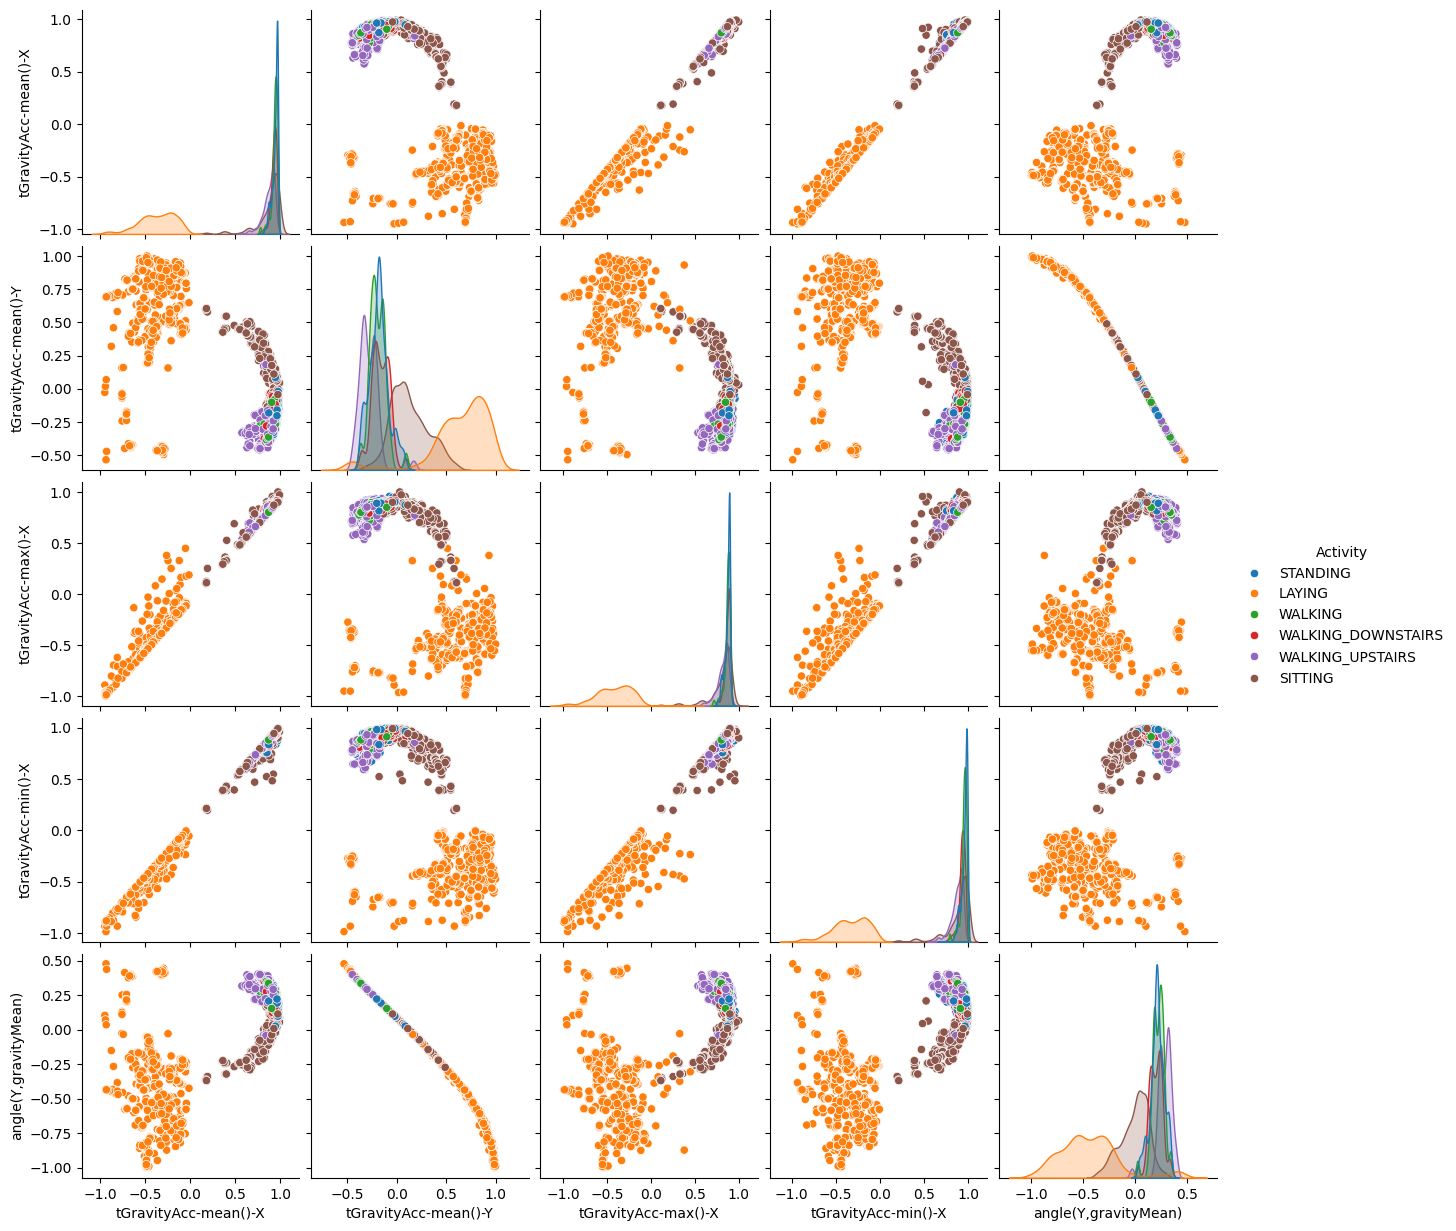

In [26]:
top_features = [feature for importance, feature in top_features]
sns.pairplot(data = data01_train, vars = top_features, hue = 'Activity')
plt.show()

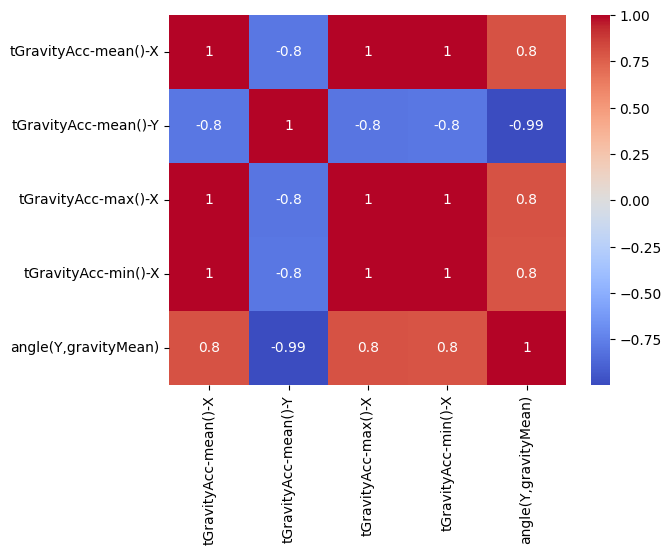

In [27]:
corr_matrix_top = data01_train[top_features].corr()
sns.heatmap(corr_matrix_top, annot = True, cmap = 'coolwarm')
plt.show()

In [28]:
data01_train[top_features].corr()

,tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-max()-X,tGravityAcc-min()-X,"angle(Y,gravityMean)"
tGravityAcc-mean()-X,1.000000,-0.798780,0.997985,0.999037,0.798671
tGravityAcc-mean()-Y,-0.798780,1.000000,-0.799205,-0.796291,-0.993482
tGravityAcc-max()-X,0.997985,-0.799205,1.000000,0.995136,0.798789
tGravityAcc-min()-X,0.999037,-0.796291,0.995136,1.000000,0.796506
"angle(Y,gravityMean)",0.798671,-0.993482,0.798789,0.796506,1.000000


#### 3) 하위 5개 변수에 대한 분석

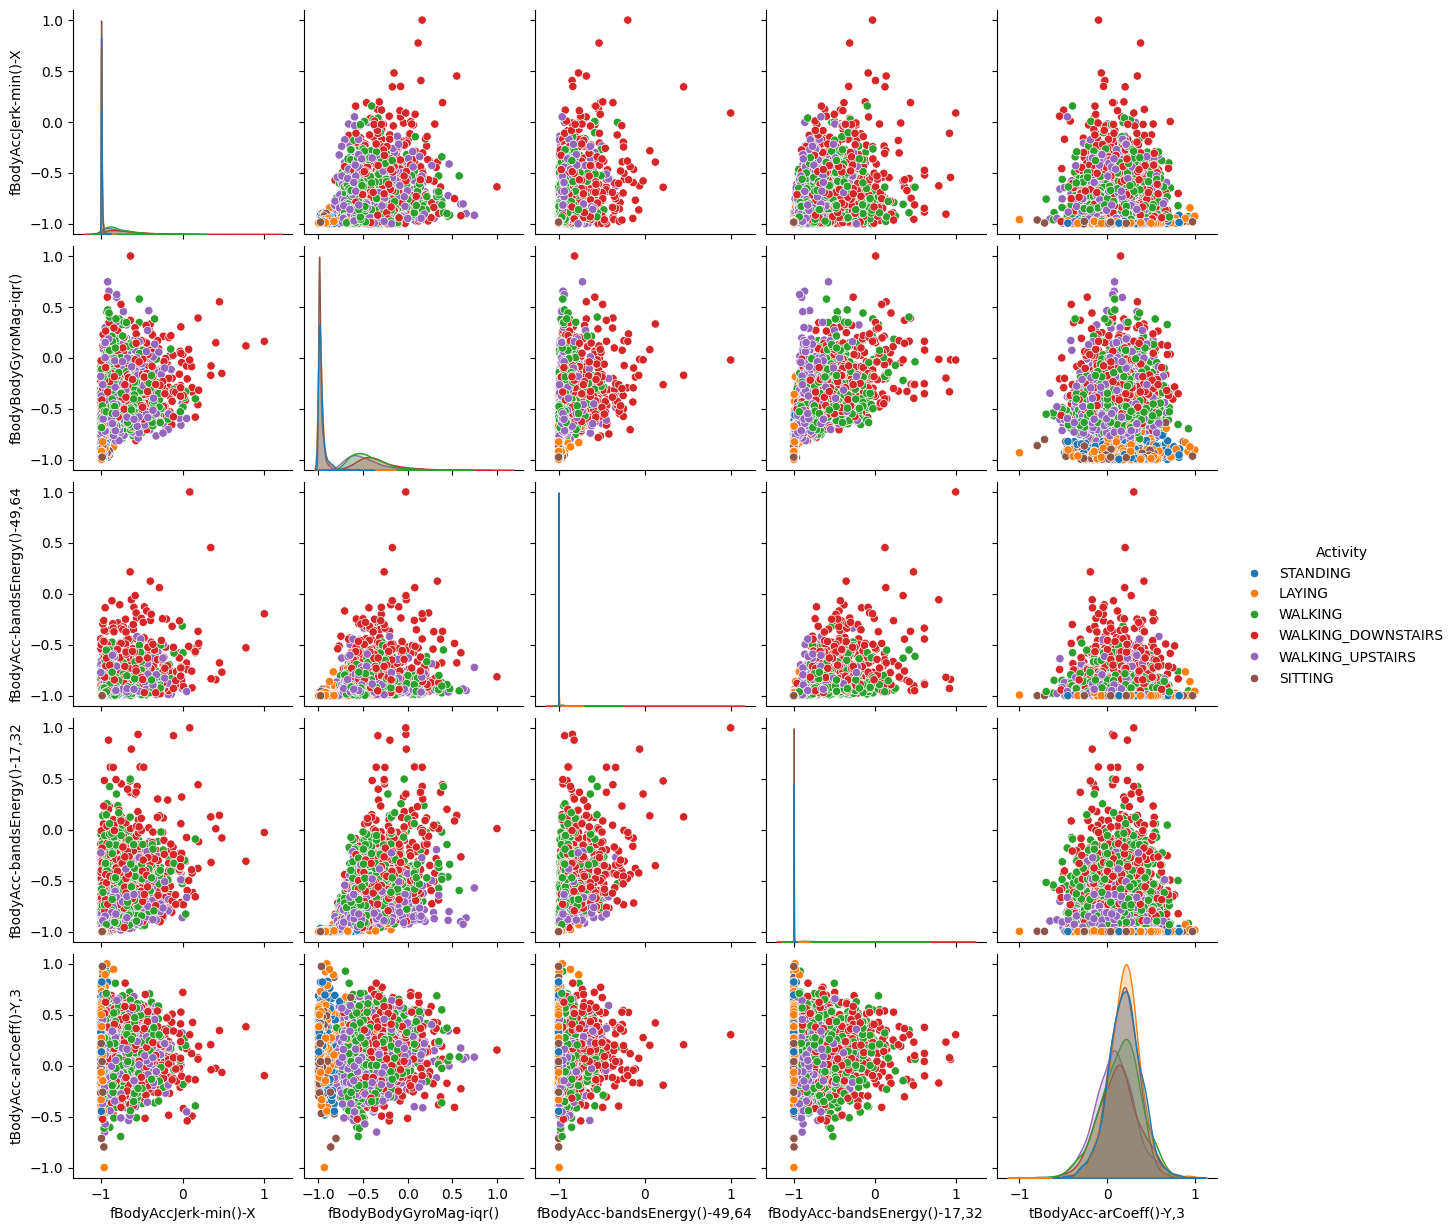

In [29]:
bottom_features = [feature for importance, feature in bottom_features]
sns.pairplot(data = data01_train, vars = bottom_features, hue = 'Activity')
plt.show()

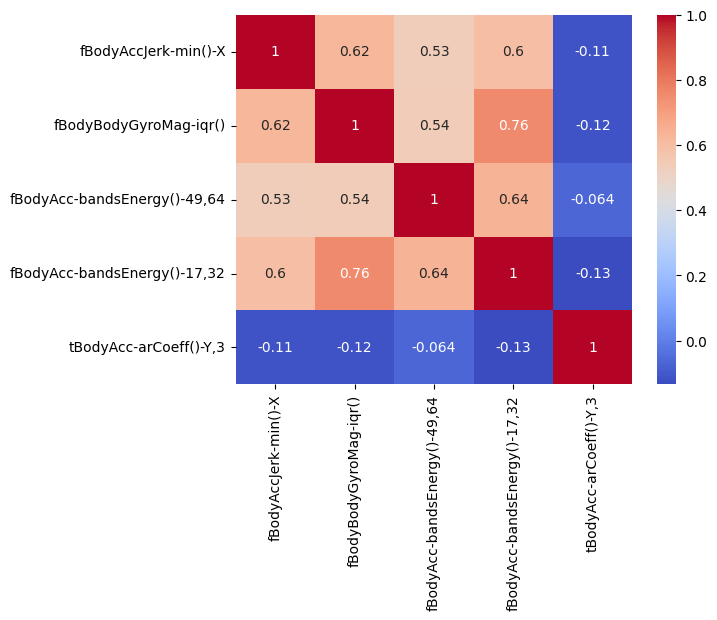

In [30]:
corr_matrix_bottom = data01_train[bottom_features].corr()
sns.heatmap(corr_matrix_bottom, annot = True, cmap = 'coolwarm')
plt.show()

In [31]:
data01_train[bottom_features].corr()

,fBodyAccJerk-min()-X,fBodyBodyGyroMag-iqr(),"fBodyAcc-bandsEnergy()-49,64","fBodyAcc-bandsEnergy()-17,32","tBodyAcc-arCoeff()-Y,3"
fBodyAccJerk-min()-X,1.000000,0.623615,0.531943,0.597329,-0.114884
fBodyBodyGyroMag-iqr(),0.623615,1.000000,0.540021,0.759408,-0.116123
"fBodyAcc-bandsEnergy()-49,64",0.531943,0.540021,1.000000,0.638166,-0.064036
"fBodyAcc-bandsEnergy()-17,32",0.597329,0.759408,0.638166,1.000000,-0.134484
"tBodyAcc-arCoeff()-Y,3",-0.114884,-0.116123,-0.064036,-0.134484,1.000000


## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [32]:
data01_train['is_dynamic'] = data01_train['Activity'].apply(lambda x: 1 if x in ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'] else 0)
data01_train['is_dynamic'].unique()

array([0, 1])

In [33]:
data01_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1


In [34]:
data01_train.drop('Activity', axis = 1, inplace = True)
data01_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,1


#### 2) 기본모델 생성

In [35]:
target = 'is_dynamic'
x = data01_train.drop(target, axis = 1)
y = data01_train.loc[:, target]

In [36]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 1)

#### 3) 변수중요도 상위 5개 분석

In [37]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

In [38]:
# Validation 데이터에 대한 예측
y_pred = model.predict(x_val)

# 정확도 평가
accuracy = accuracy_score(y_val, y_pred)

print("Validation Accuracy:", accuracy)


Validation Accuracy: 0.9983007646559049


In [39]:
importance = model.feature_importances_
feature_names = x_train.columns
feature_importance = sorted(zip(importance, feature_names), reverse = True)
print(feature_importance)

[(0.05984556578520584, 'fBodyAcc-mad()-X'), (0.0500715228615557, 'tBodyAccJerk-mad()-X'), (0.049726066198377515, 'fBodyAccJerk-sma()'), (0.04007663672290583, 'fBodyAccJerk-bandsEnergy()-1,8'), (0.03994008004863642, 'fBodyAccJerk-energy()-X'), (0.03976040821414004, 'tBodyAccJerk-mad()-Y'), (0.030162698140146188, 'fBodyAccJerk-bandsEnergy()-1,16'), (0.030153890528809235, 'fBodyAccJerk-mean()-X'), (0.030102521654317833, 'tBodyAccJerk-sma()'), (0.03004323669009086, 'fBodyAccJerk-bandsEnergy()-1,24'), (0.030025790155643536, 'fBodyAccJerk-entropy()-X'), (0.02999140948731143, 'fBodyAccJerk-max()-X'), (0.029974243973838823, 'fBodyAccJerk-std()-X'), (0.029940021001857522, 'fBodyAccJerk-mad()-X'), (0.02031561928814318, 'tBodyAccJerk-energy()-X'), (0.02013656498641439, 'tBodyAccJerk-std()-X'), (0.020051238885598434, 'tBodyAccJerk-iqr()-X'), (0.020034228992007592, 'tBodyGyroJerk-mad()-Z'), (0.019965764578959815, 'tBodyAccJerkMag-sma()'), (0.019923075653661203, 'fBodyAcc-entropy()-X'), (0.019922634

In [40]:
plot_feature_importance(importance, feature_names, result_only = True)

,feature_name,feature_importance
0,fBodyAcc-mad()-X,0.059846
1,tBodyAccJerk-mad()-X,0.050072
2,fBodyAccJerk-sma(),0.049726
3,"fBodyAccJerk-bandsEnergy()-1,8",0.040077
4,fBodyAccJerk-energy()-X,0.039940
...,...,...
556,"tGravityAcc-correlation()-X,Y",0.000000
557,tBodyGyroJerkMag-arCoeff()4,0.000000
558,tBodyGyroJerkMag-arCoeff()3,0.000000
559,tBodyGyroJerkMag-arCoeff()2,0.000000


In [41]:
top_features = feature_importance[:5]
for importance, feature in top_features:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: fBodyAcc-mad()-X, Importance: 0.05984556578520584
Feature: tBodyAccJerk-mad()-X, Importance: 0.0500715228615557
Feature: fBodyAccJerk-sma(), Importance: 0.049726066198377515
Feature: fBodyAccJerk-bandsEnergy()-1,8, Importance: 0.04007663672290583
Feature: fBodyAccJerk-energy()-X, Importance: 0.03994008004863642


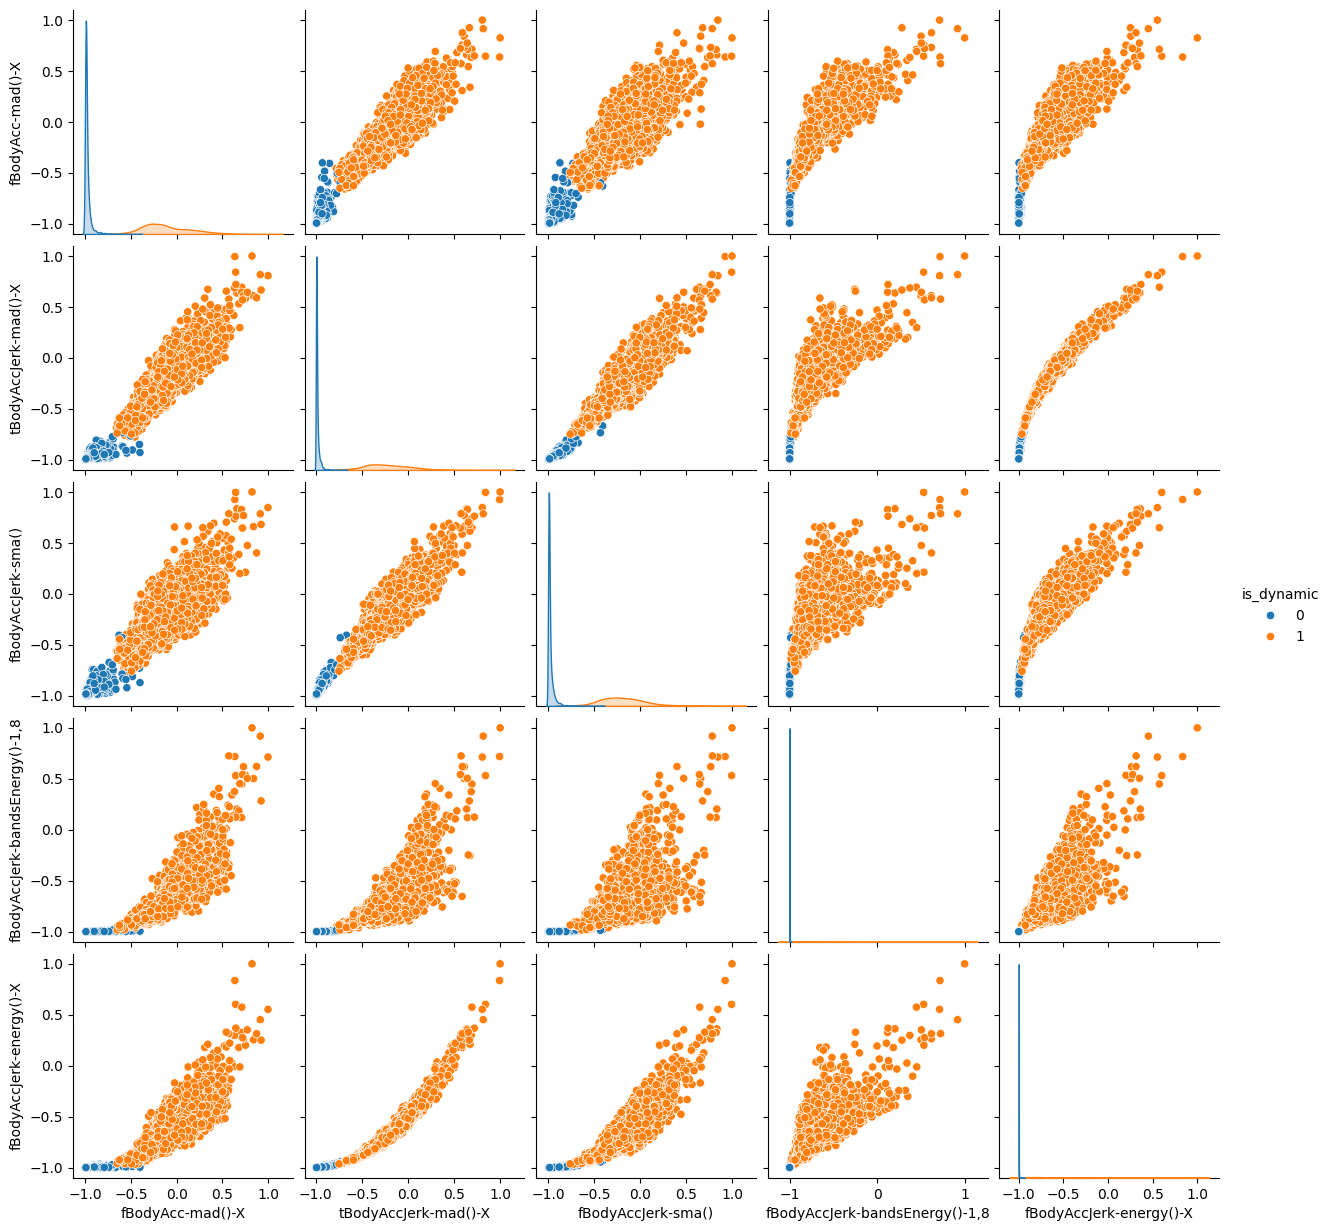

In [42]:
top_features = [feature for importance, feature in top_features]
sns.pairplot(data = data01_train, vars = top_features, hue = 'is_dynamic')
plt.show()

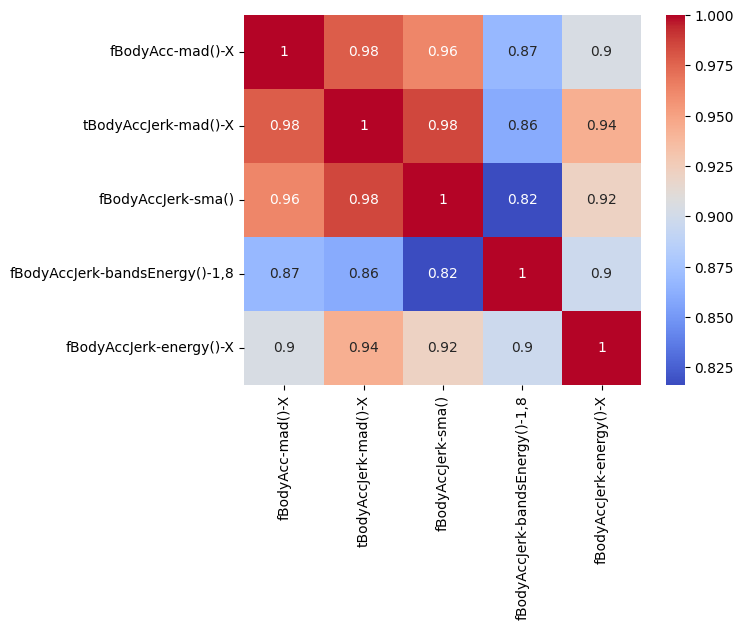

In [43]:
corr_matrix_top = data01_train[top_features].corr()
sns.heatmap(corr_matrix_top, annot = True, cmap = 'coolwarm')
plt.show()

In [44]:
data01_train[top_features].corr()

,fBodyAcc-mad()-X,tBodyAccJerk-mad()-X,fBodyAccJerk-sma(),"fBodyAccJerk-bandsEnergy()-1,8",fBodyAccJerk-energy()-X
fBodyAcc-mad()-X,1.000000,0.978403,0.962242,0.867777,0.904450
tBodyAccJerk-mad()-X,0.978403,1.000000,0.984989,0.860100,0.943479
fBodyAccJerk-sma(),0.962242,0.984989,1.000000,0.816359,0.920384
"fBodyAccJerk-bandsEnergy()-1,8",0.867777,0.860100,0.816359,1.000000,0.897073
fBodyAccJerk-energy()-X,0.904450,0.943479,0.920384,0.897073,1.000000


In [45]:
feature_importance

[(0.05984556578520584, 'fBodyAcc-mad()-X'),
 (0.0500715228615557, 'tBodyAccJerk-mad()-X'),
 (0.049726066198377515, 'fBodyAccJerk-sma()'),
 (0.04007663672290583, 'fBodyAccJerk-bandsEnergy()-1,8'),
 (0.03994008004863642, 'fBodyAccJerk-energy()-X'),
 (0.03976040821414004, 'tBodyAccJerk-mad()-Y'),
 (0.030162698140146188, 'fBodyAccJerk-bandsEnergy()-1,16'),
 (0.030153890528809235, 'fBodyAccJerk-mean()-X'),
 (0.030102521654317833, 'tBodyAccJerk-sma()'),
 (0.03004323669009086, 'fBodyAccJerk-bandsEnergy()-1,24'),
 (0.030025790155643536, 'fBodyAccJerk-entropy()-X'),
 (0.02999140948731143, 'fBodyAccJerk-max()-X'),
 (0.029974243973838823, 'fBodyAccJerk-std()-X'),
 (0.029940021001857522, 'fBodyAccJerk-mad()-X'),
 (0.02031561928814318, 'tBodyAccJerk-energy()-X'),
 (0.02013656498641439, 'tBodyAccJerk-std()-X'),
 (0.020051238885598434, 'tBodyAccJerk-iqr()-X'),
 (0.020034228992007592, 'tBodyGyroJerk-mad()-Z'),
 (0.019965764578959815, 'tBodyAccJerkMag-sma()'),
 (0.019923075653661203, 'fBodyAcc-entropy(

In [46]:
acc_features = [(importance, name) for importance, name in feature_importance if 'Acc' in name]
acc_features.sort(reverse=True)

print("Important Acc features")
for importance, name in acc_features[:5]:  # 상위 5개
    print(f'{name} : {importance}')

Important Acc features
fBodyAcc-mad()-X : 0.05984556578520584
tBodyAccJerk-mad()-X : 0.0500715228615557
fBodyAccJerk-sma() : 0.049726066198377515
fBodyAccJerk-bandsEnergy()-1,8 : 0.04007663672290583
fBodyAccJerk-energy()-X : 0.03994008004863642


In [47]:
gyro_features = [(importance, name) for importance, name in feature_importance if 'Gyro' in name]
gyro_features.sort(reverse=True)

print("Important Gyro features:")
for importance, name in gyro_features[:5]:  # 상위 5개
    print(f'{name} : {importance}')

Important Gyro features:
tBodyGyroJerk-mad()-Z : 0.020034228992007592
fBodyGyro-sma() : 0.019905969718773488
tBodyGyroJerk-entropy()-Z : 0.01988060478946284
tBodyGyroJerk-iqr()-Z : 0.009975572048399491
tBodyGyroJerk-sma() : 0.009965672320626656


In [48]:
acc_mean_features = [(importance, name) for importance, name in acc_features if 'mean()' in name]
acc_mean_features.sort(reverse=True)

print("Important mean features:")
for importance, name in acc_mean_features[:5]:  # 상위 5개
    print(f'{name} : {importance}')

Important mean features:
fBodyAccJerk-mean()-X : 0.030153890528809235
fBodyAccJerk-mean()-Y : 0.019828951460344673
tBodyAccJerkMag-mean() : 0.010042770147623028
fBodyAcc-mean()-X : 0.009967791240825474
fBodyBodyAccJerkMag-mean() : 0.009863866671712471


In [49]:
gyro_mean_features = [(importance, name) for importance, name in gyro_features if 'mean()' in name]
gyro_mean_features.sort(reverse=True)

print("Important mean features:")
for importance, name in gyro_mean_features[:5]:  # 상위 5개
    print(f'{name} : {importance}')

Important mean features:
fBodyGyro-mean()-Y : 1.5299687488191007e-05
tBodyGyroMag-mean() : 0.0
tBodyGyroJerkMag-mean() : 0.0
tBodyGyroJerk-mean()-Z : 0.0
tBodyGyroJerk-mean()-Y : 0.0
